# Image Caption Generator
Importing required libraries

In [1]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

Declaring the directory of the *flickr8k* image dataset

In [2]:
BASE_DIR = 'flickr8k'

## Extract Image Features
Load VGG16 model

In [3]:
model = VGG16()

Re-structure and summarize the model

In [4]:
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

Extracting features from image.<br>
*Remember!* After the extracting the features, don't run this cell. Instead, load the features from the *pkl* file containing features.

In [11]:
features = {}
directory = os.path.join(BASE_DIR, "Images")

for img_name in tqdm(os.listdir(directory)):
    # load the image from the file
    img_path = directory + "/" + img_name
    image = load_img(img_path, target_size=(224, 224))
    # convert the image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape(1, image.shape[0], image.shape[1], image.shape[2])
    # preprocess image for vgg16
    image = preprocess_input(image)
    # extract features
    feature = model.predict(image, verbose=0)
    # get image ID
    image_id = img_name.split('.')[0]
    # store the extracted feature
    features[image_id] = feature

  0%|          | 0/8091 [00:00<?, ?it/s]

After the extracting the features, we don't want them to lose, so we will store them in a *pkl* file.<br>
*Note*: No need to run this as well because it is used to save the extracted features which is already done.

In [18]:
# storing the features in pickle
with open(os.path.join('features.pkl'), 'wb') as f:
    pickle.dump(features, f)

Load features from *pickle*

In [5]:
with open(os.path.join('features.pkl'), 'rb') as f:
    features = pickle.load(f)

### Load the Caption data

In [6]:
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    # use next() to avoid the heading to in the captions.txt
    next(f)
    captions_doc = f.read()

Creating mapping of images to captions

In [7]:
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma (,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image_id
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [8]:
len(mapping)

8091

### Preprocess Text data
Preprocessing the captions

In [9]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take on caption at a time
            caption = captions[i]
            # convert to lower
            caption = caption.lower()
            # remove digits, special characters etc. 
            caption = caption.replace('^[A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word) > 1]) + ' endseq'
            captions[i] = caption

Before preprocess of text

In [10]:
mapping['3700004668_99c3e3f55b']

['A boy with his mouth wide open dressed in a yellow life jacket and goggles in water with a man next to him .',
 'A father and child enjoy the water .',
 'A man and child wearing a yellow life vest look up from the water .',
 'An open mouthed child in goggles and a yellow life vest poses with a smiling man .',
 'Man and boy wearing life jacket in water posing for a picture']

Preprocess the text

In [11]:
clean(mapping)

After preprocessing the text

In [12]:
mapping['3700004668_99c3e3f55b']

['startseq boy with his mouth wide open dressed in yellow life jacket and goggles in water with man next to him endseq',
 'startseq father and child enjoy the water endseq',
 'startseq man and child wearing yellow life vest look up from the water endseq',
 'startseq an open mouthed child in goggles and yellow life vest poses with smiling man endseq',
 'startseq man and boy wearing life jacket in water posing for picture endseq']

Now, we will create a tokenizer and store all the caption in a single list

In [13]:
all_captions = []
for key in mapping.keys():
    for caption in mapping[key]:
        all_captions.append(caption)

In [14]:
len(all_captions)

40455

Let's check the first 10 captions

In [15]:
all_captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

Tokenize the text

In [16]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [17]:
vocab_size

8485

Get the maximum length of the caption

In [18]:
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

### Train Test Split

In [19]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

### Data Generator
*Remember*: We usually create this devices with less 16 GB RAM to avoid crashes.<br><br>
<strong>How will the Sequence X, y pairing work?</strong><br>
*Example: <strong>startseq</strong> girl going into wooden building <strong>endseq</strong>*

| |X|y||
|:---:|:---:|:---:|:---:|
|startseq||girl||
|startseq|girl|going||
|startseq|girl going|into||
|startseq|girl going into|wooden||
|startseq|girl going into wooden|building||
|startseq|girl going into wooden building||endseq|

In [20]:
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while True:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split inti input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

### Model Creation

In [21]:
# encoder model

# image feature layers
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)

model.compile(loss='categorical_crossentropy', optimizer='adam')

<strong>Model structure</strong> (get from *Google Colab*)
<img src="model.png">

*Remember*: In last layer (Output Layer), the output shape is <strong>8483</strong>

## Training the model

*Remember*: Don't run the below code if model is already trained. This might take a lots of time if using <strong>CPU</strong> only.<br>
I have trained this model on <strong>NVidia RTX 3050</strong> (trained in 13 minutes). Also, we can change the number of epochs.

In [22]:
epochs = 15
batch_size = 64
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

113/113 [==============================] - 36s 316ms/step - loss: 2.4859


<strong>*Warning!*</strong>: Don't run this command after the trained model is saved. Otherwise, the trained model will get replaced by a base model.<br>
For saving the trained model<br>
<strong>P.S.</strong> I am also changing the save name of the model, to avoid replacing the previous model.

In [23]:
model.save('second_model.h5')

## Generate captions for the Images
Helper function

In [24]:
def index_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

Generate caption for an image

In [25]:
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the generation process
    for i in range(max_length):
        # encode the input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = index_to_word(yhat, tokenizer)
        # stop if word is not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach the end tag
        if word == 'endseq':
            break
        
    return in_text

### Validate with test data
Loading the saved model

In [26]:
from tensorflow.keras.models import load_model

model = load_model('second_model.h5')
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 35)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 4096)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 35, 256)      2172160     ['input_3[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 4096)         0           ['input_2[0][0]']                
                                                                                            

Whenever dealing with the textual data, we consider the *BLEU Score*

In [27]:
from nltk.translate.bleu_score import corpus_bleu

actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append into words
    actual.append(actual_captions)
    predicted.append(y_pred)

# calculate the BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.551677
BLEU-2: 0.329106


<strong>BLEU Scores of First Model:</strong><br>
- *BLEU-1*: 0.148996 (Approx.)
- *BLEU-2*: 0.089858 (Approx.)
<br><br>
<strong>BLEU Scores of Second Model:</strong><br>
- *BLEU-1*: 0.551677 (Approx.)
- *BLEU-2*: 0.329106 (Approx.)

<strong>General Information</strong>: BLEU Score above 0.44 is usually considered good because we cannot predict the exact words. Training model on more *epochs* can help us to achieve higher BLEU Score.

## Visualize the results

In [28]:
from PIL import Image
import matplotlib.pyplot as plt

def generate_caption(image_name):
    # load the image
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print("------------------------------Actual------------------------------")
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print("------------------------------Predicted------------------------------")
    print(y_pred)
    plt.imshow(image)

------------------------------Actual------------------------------
startseq blonde horse and blonde girl in black sweatshirt are staring at fire in barrel endseq
startseq girl and her horse stand by fire endseq
startseq girl holding horse 's lead behind fire endseq
startseq "a man and girl and two horses are near contained fire ." endseq
startseq two people and two horses watching fire endseq
------------------------------Predicted------------------------------
startseq two horses are playing with fire endseq


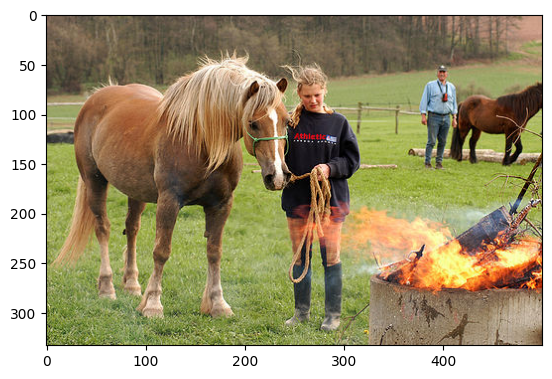

In [29]:
generate_caption('10815824_2997e03d76.jpg')

------------------------------Actual------------------------------
startseq black dog running in the surf endseq
startseq black lab with tags frolicks in the water endseq
startseq dog splashes in the water endseq
startseq the black dog runs through the water endseq
startseq this is black dog splashing in the water endseq
------------------------------Predicted------------------------------
startseq black dog is swimming in the water endseq


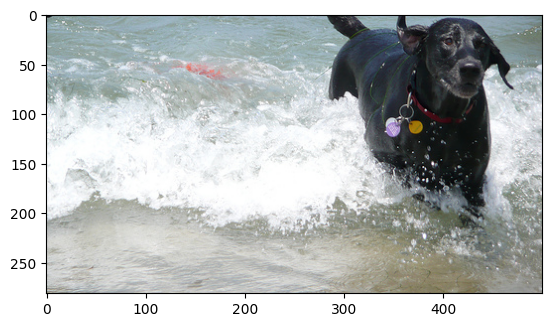

In [30]:
generate_caption('1022975728_75515238d8.jpg')